In [1]:
from utils import featurize_merge
import numpy as np

In [10]:
def multiply_permutations(sigma, tau):
    """
    Multiply two permutations sigma and tau (in the order sigma(tau(x))).
    Both sigma and tau are represented as lists of integers where the ith
    element of the list represents sigma(i+1) or tau(i+1).
    """
    # Adjust for 0-based indexing by using tau[i]-1 as the index in sigma.
    # The result is adjusted back by subtracting 1 inside the lookup.
    result = [sigma[tau[i-1]-1] for i in range(len(tau))]
    return result

multiply_permutations([2,1,0], [0,2,1])

[2, 0, 1]

In [11]:
multiply_permutations([0,2,1], [2,1,0])

[1, 2, 0]

In [86]:
a = np.array([0,1,2,3,4])
b = np.array([2,3,1,4,0])

c = np.array([4,3,0,1,2])

t = np.array([a, b, a[c], b[c]])
print(t)

featurize_merge(t)

[[0 1 2 3 4]
 [2 3 1 4 0]
 [4 3 0 1 2]
 [0 4 2 3 1]]


[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1, 0, 0, 0],
 [0, 1, 1, 1, 0, 1, 1, 1]]

In [85]:
a = np.array([0,1,2,3,4])
b = np.array([2,3,1,4,0])

c = np.array([4,3,0,1,2])

t = np.array([a, b, c[a], c[b]])
print(t)

featurize_merge(t)

[[0 1 2 3 4]
 [2 3 1 4 0]
 [4 3 0 1 2]
 [0 1 3 2 4]]


[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0]]

## Result Collection

In [2]:
import torch
from torch import load
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

In [6]:
def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False,
                       model_top=None,
                       model_medium=None,
                       model_bottom=None, 
                       reverse=False, 
                       legend_labels=None):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    if legend_labels is None:
        labels = [None for i in range(len(colors))]
        zipper = zip(colors, xvals, yvals, labels)
    else:
        zipper = zip(colors, xvals, yvals, legend_labels)

    for color, x, Y, label in zipper:
        
        if reverse:
            Y = -Y
        bot, mid, top = [_.ravel() for _ in
                         np.percentile(Y, [25, 50, 75], axis=0)]
        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color, label=label)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    if model_top is not None:
        if use_fill_between:
            ax.fill_between(x, model_bottom.flat, model_top.flat, color=color, alpha=0.15)
        for x in xvals:
            ax.plot(x, model_top, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_bottom, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_medium, color=[158, 218, 229])

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

    # set the alignment for outer ticklabels
    ax.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")
    ax.legend()
    
    
model_list = [
    'kendall',
    'spearman',
    'mallows',
]


tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(model_list)]  # color bar

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

def save_result_image(result_daraframes, result_daraframes_1, save_name):
    x_vals = []
    lengths = [result_dataframe.shape[1] for result_dataframe in result_daraframes]
    for i in range(len(result_daraframes)):
        x = np.arange(0, min(lengths), 1)
        x_vals.append(x)
        result_daraframes[i] = result_daraframes[i].iloc[:, :min(lengths)]
        
    fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
    results_plot_maker(a[0], result_daraframes, x_vals, 'Iteration', save_name, 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
    results_plot_maker(a[1], result_daraframes_1, x_vals, 'Iteration', 'Simple regret', 'Simple regret', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, legend_labels=model_list)
    # plt.legend()
    plt.savefig(save_name+'.pdf', format='pdf')


def transform_to_regret(nd_array, global_min=None):
    if global_min is None:
        global_min = 0
    nd_regret = []
    for array in nd_array:
        current_min = array.max()
        regret = []
        for i in array:
            current_min = min(current_min, i)
            regret.append(current_min - global_min)
        nd_regret.append(regret)
    return np.array(nd_regret)

In [8]:
FILE_LIST = ['qap_kendall_ts_sdp_benchmark_index_3_{}.pkl'.format(i) for i in range(15)]
DIR = './results_collection/permutation'

result_kendall = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_kendall.append(data['outputs'].numpy())
qap_kendall = np.array(result_kendall)

FILE_LIST = ['qap_spearman_ts_sdp_benchmark_index_3_15_{}.pkl'.format(i) for i in range(15)]
result_spearman = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_spearman.append(data['outputs'])
qap_spearman = np.array(result_spearman)

FILE_LIST = ['qap_botorch_mallows_EI_benchmark_index_3_nrun_{}.pkl'.format(i) for i in range(15)]
result_mallows = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_mallows.append(data['outputs'])
qap_mallows = np.array(result_mallows)

<ipython-input-8-3301c87776c9>:15: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  qap_spearman = np.array(result_spearman)
<ipython-input-8-3301c87776c9>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qap_spearman = np.array(result_spearman)


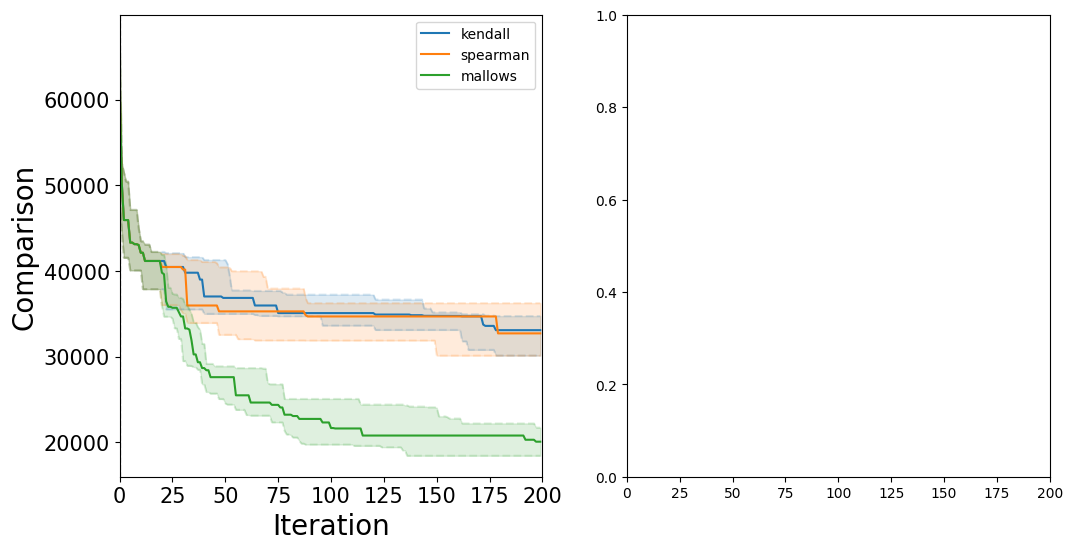

In [9]:
qap_kendall = transform_to_regret(qap_kendall, 0)
qap_spearman = transform_to_regret(qap_spearman, 0)
qap_mallows = transform_to_regret(qap_mallows, 0)

x_vals = [np.arange(0, 200, 1) for i in range(3)]

fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
results_plot_maker(a[0], [qap_kendall, qap_spearman, qap_mallows], x_vals, 'Iteration', 'Comparison', 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
plt.show()

In [29]:
FILE_LIST = ['tsp_botorch_rbf_EI_dim_10benchmark_index_0_nrun_{}.pkl'.format(i) for i in range(20)]
DIR = './results_collection/permutation'

result_rbf = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_rbf.append(data['outputs'])
tsp_rbf = np.array(result_rbf)

FILE_LIST = ['tsp_botorch_mallows_EI_dim_10benchmark_index_0_nrun_{}.pkl'.format(i) for i in range(20)]
result_mallows = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_mallows.append(data['outputs'])
tsp_mallows = np.array(result_mallows)

FILE_LIST = ['tsp_kendall_ts_sdp_benchmark_index_0_10_{}.pkl'.format(i) for i in range(15)]
result_kendall = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_mallows.append(data['outputs'])
tsp_kendall = np.array(result_mallows)

<ipython-input-29-eebe11ddddeb>:22: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  tsp_kendall = np.array(result_mallows)
<ipython-input-29-eebe11ddddeb>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tsp_kendall = np.array(result_mallows)


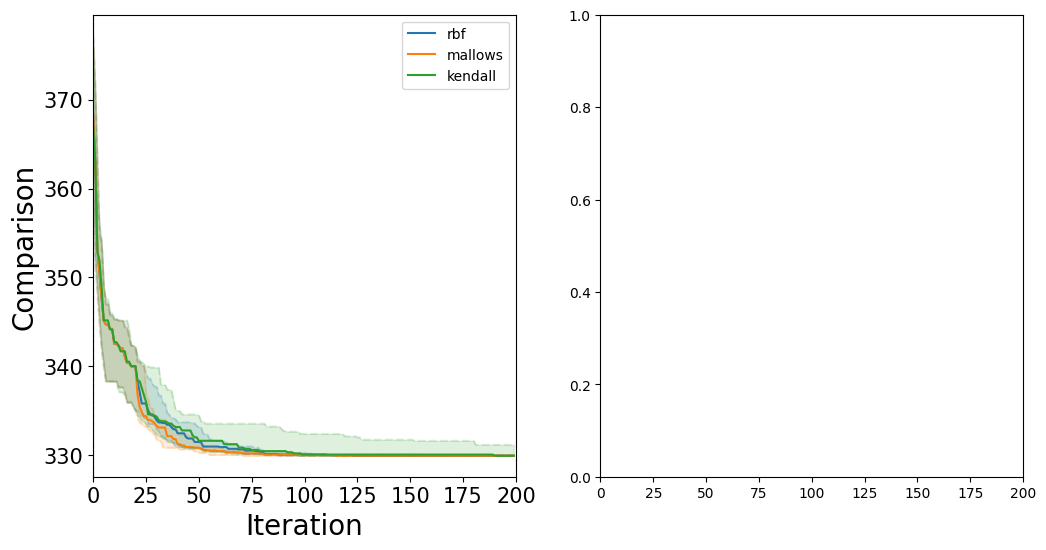

In [14]:
tsp_rbf = transform_to_regret(tsp_rbf, 0)
tsp_mallows = transform_to_regret(tsp_mallows, 0)
tsp_kendall = transform_to_regret(tsp_kendall, 0)

x_vals = [np.arange(0, 200, 1) for i in range(3)]

model_list = [
    'rbf',
    'mallows',
    'kendall',
]


fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
results_plot_maker(a[0], [tsp_rbf, tsp_mallows, tsp_kendall], x_vals, 'Iteration', 'Comparison', 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
plt.show()

In [42]:
FILE_LIST = ['qap_botorch_rbf_EI_benchmark_index_3_nrun_{}.pkl'.format(i) for i in range(14)]
DIR = './results_collection/permutation'

result_rbf = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_rbf.append(data['outputs'])
qap_rbf = np.array(result_rbf)

FILE_LIST = ['qap_botorch_mallows_EI_benchmark_index_3_nrun_{}.pkl'.format(i) for i in range(14)]
result_mallows = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_mallows.append(data['outputs'])
qap_mallows = np.array(result_mallows)

FILE_LIST = ['qap_kendall_ts_sdp_benchmark_index_3_{}.pkl'.format(i) for i in range(14)]
result_kendall = []
for FILE in FILE_LIST:
    data = load(os.path.join(DIR, FILE))
    result_kendall.append(data['outputs'])
qap_kendall = np.array(result_kendall)


<ipython-input-42-d562eff8e40a>:22: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  qap_kendall = np.array(result_kendall)
<ipython-input-42-d562eff8e40a>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qap_kendall = np.array(result_kendall)


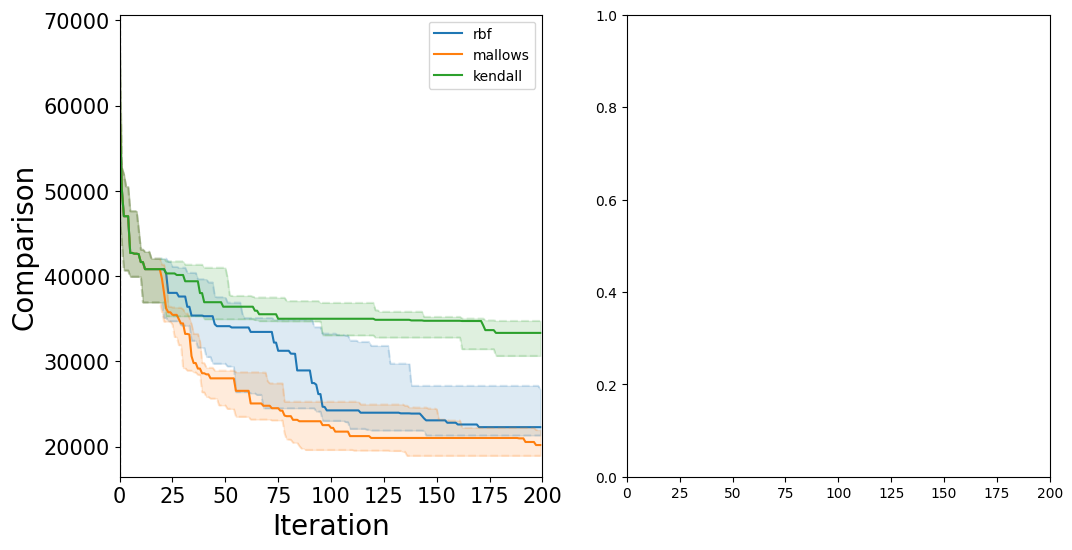

In [44]:
qap_rbf = transform_to_regret(qap_rbf, 0)
qap_mallows = transform_to_regret(qap_mallows, 0)
qap_kendall = transform_to_regret(qap_kendall, 0)

model_list = [
    'rbf',
    'mallows',
    'kendall',
]

x_vals = [np.arange(0, 200, 1) for i in range(3)]

fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
results_plot_maker(a[0], [qap_rbf, qap_mallows, qap_kendall], x_vals, 'Iteration', 'Comparison', 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
plt.show()

In [41]:
np.array(qap_kendall, dtype=float)

array([[66000., 52854., 53768., ..., 32248., 36392., 58810.],
       [57458., 32496., 60220., ..., 50468., 27620., 33526.],
       [68944., 65146., 80072., ..., 51708., 79970., 86740.],
       ...,
       [78514., 50620., 52864., ..., 63600., 59326., 69456.],
       [43308., 62614., 71900., ..., 32010., 43528., 53552.],
       [45944., 61102., 56192., ..., 49026., 44616., 46162.]])